In [1]:
import pandas as pd
import numpy as np
import typing
save_plot = True
debug = True
data_dir = '../data/dianli.xlsx'
data = pd.read_excel(data_dir,nrows=1000 if debug else None)

In [3]:
raw_data_copy = data.copy()
raw_data_copy.columns = ['date', 'hour',
                         'f1', 'f2', 'f3', 'f4', 'f5', 'target']
raw_data_copy = raw_data_copy[['f1', 'f2', 'f3', 'f4', 'f5', 'target']]
targ_cols = ("target",)  # NDX是我们需要预测的值

,f1,f2,f3,f4,f5,target
0,23.9,21.65,22.4,87.5,19.67,8013.27833


In [8]:
# 数据预处理
class TrainConfig(typing.NamedTuple):
    T: int
    train_size: int
    batch_size: int
    loss_func: typing.Callable


class TrainData(typing.NamedTuple):
    feats: np.ndarray
    targs: np.ndarray
    
from sklearn.preprocessing import StandardScaler
def read2Dataloader(data,col_names):
    scaler = StandardScaler().fit(data)
    proc_dat = scaler.transform(data)
    mask = np.ones(proc_dat.shape[1],dtype=bool)
    dat_cols = list(data.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False
    feats = proc_dat[:,mask]
    targs = proc_dat[:,~mask]
    return TrainData(feats,targs)
# 返回特征
trainData = read2Dataloader(raw_data_copy,targ_cols)

In [45]:
'''
基本网络类型
'''
import torch.nn as nn
import json
from torch import optim
import collections
import typing

'''
初始化简单的lstm网络
'''
RnnNet = collections.namedtuple("RnnNet",["rnn","rnn_optimizer"])
class Lstm(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers , output_size , dropout, batch_first):
        super(Lstm, self).__init__()
        # lstm的输入 #batch,seq_len, input_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first

        self.rnn = nn.LSTM(input_size=self.input_size, 
                           hidden_size=self.hidden_size, 
                           num_layers=self.num_layers, 
                           batch_first=self.batch_first, 
                           dropout=self.dropout)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        out, (hidden, cell) = self.rnn(x)  # x.shape : batch, seq_len, hidden_size , hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        # a, b, c = hidden.shape
        # out = self.linear(hidden.reshape(a * b, c))
        out = self.linear(hidden)
        return out


In [46]:
def rnn(train_data: TrainData, n_targs: int, hidden_size:int, T:int, learning_rate=0.001, batch_size=128):

    # 定义配置器 T=>滑窗长度 截取前70%的数据作为训练集
    train_cfg = TrainConfig(
        T, int(train_data.feats.shape[0] * 0.7), batch_size, nn.MSELoss())
    print('train size: ',train_cfg.train_size)


    input_size = train_data.feats.shape[1] 
    print('input size: ',input_size +1)
    # 初始化网络结构
    rnn_args = {
        "input_size" :input_size + 1,
        "hidden_size" : hidden_size,
        "num_layers" : 1,
        "output_size" : 1,
        "dropout" : 0,
        "batch_first":True
    }
    print ("run args: ", rnn_args)
    rnn  = Lstm(**rnn_args)
    with open( ('../data/lstm.json'),"w") as fi: 
        json.dump(rnn_args,fi,indent=4)

    rnn_optimizer = optim.Adam(
        params=rnn.parameters(),
        lr=learning_rate
    )
    # 返回的网络结构
    rnn_net = RnnNet(
        rnn,rnn_optimizer
    )
    return train_cfg, rnn_net

In [47]:
# 初始化模型参数
init_args = {"batch_size": 128, "T": 10}
rnn_kwargs = init_args
config, model = rnn(trainData, n_targs=len(targ_cols),hidden_size=64,T=10,learning_rate=.001,batch_size=128)

train size:  700
input size:  6
run args:  {'input_size': 6, 'hidden_size': 64, 'num_layers': 1, 'output_size': 1, 'dropout': 0, 'batch_first': True}


In [53]:
# 平滑处理序列 开始训练
import torch
from torch.autograd import Variable
def PrepareData(batch_idx,t_cfg,train_data):
    feats = np.zeros((len(batch_idx), t_cfg.T - 1 , train_data.feats.shape[1]))
    y_history = np.zeros((len(batch_idx) ,t_cfg.T - 1 , train_data.targs.shape[1]))
    y_target = train_data.targs[batch_idx + t_cfg.T]
    # 获取采样的batch_id的下标和值
    # 获取特征和标签的相应下标值
    for b_i, b_idx in enumerate(batch_idx):
        b_slc = slice(b_idx, b_idx + t_cfg.T-1)
        #print('b_i',b_i,'b_slc',b_slc)
        feats[b_i, :, :] = train_data.feats[b_slc, :]
        #print(y_history[b_i : ].shape,train_data.targs[b_slc].shape)
        y_history[b_i :] = train_data.targs[b_slc]

    return feats, y_history, y_target


def rnn_train_iteration(t_net: RnnNet, loss_func: typing.Callable, X, y_history, y_target):
    input_data = np.append(X, y_history, axis=2)
    # print(input_data.shape)
    data1 = torch.from_numpy(input_data).to(torch.float32)
    pred = t_net.rnn(Variable(data1))
    pred = pred[0, :, :]
    label = torch.from_numpy(y_target).to(torch.float32).unsqueeze(1)
    loss = loss_func(pred, label)
    t_net.rnn_optimizer.zero_grad()
    loss.backward()
    t_net.rnn_optimizer.step()
    return loss.item()


In [84]:
'''
utils
'''

import logging
import os

import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def setup_log(tag='VOC_TOPICS'):
    # create logger
    logger = logging.getLogger(tag)
    # logger.handlers = []
    logger.propagate = False
    logger.setLevel(logging.DEBUG)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    # logger.handlers = []
    logger.addHandler(ch)
    return logger


def save_or_show_plot(file_nm: str, save: bool):
    if save:
        plt.savefig( file_nm)
    else:
        plt.show()


def numpy_to_tvar(x):
    return Variable(torch.from_numpy(x).type(torch.FloatTensor).to(device))


2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.074, val loss: 0.7744591181763364.
2021-09-04 13:15:23,383 - VOC_TOPICS - INFO - Epoch 0, train los

model params:  Lstm(
  (rnn): LSTM(6, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
iter_per_epoch:  700 128 6
iter_losses:  (180,)
一共 30 次迭代
现在是第  0 轮迭代
开始预测
当前是测试阶段
y_pred shape:  (300, 1)
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([44, 9, 6])
当前是训练阶段
y_pred shape:  (691, 1)
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([128, 9, 6])
input_data shape torch.Size([51, 9, 6])
1 1001
10 701
701 1001
300 300
rmse:  0.9018291717918815
mae:  0.7744591181763364


NameError: name '__file__' is not defined

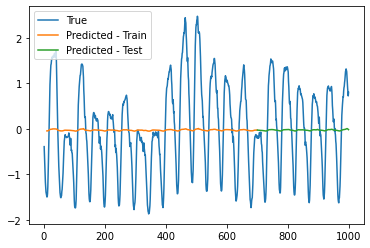

In [85]:
import matplotlib.pyplot as plt
logger = setup_log()
from sklearn.metrics import mean_squared_error,mean_absolute_error


def adjust_learning_rate(net: RnnNet, n_iter: int):
    # TODO: Where did this Learning Rate adjustment schedule come from?
    # Should be modified to use Cosine Annealing with warm restarts https://www.jeremyjordan.me/nn-learning-rate/
    if n_iter % 10000 == 0 and n_iter > 0:
        for enc_params, dec_params in zip(net.enc_opt.param_groups, net.dec_opt.param_groups):
            enc_params['lr'] = enc_params['lr'] * 0.9
            dec_params['lr'] = dec_params['lr'] * 0.9

'''
预测代码
'''
def predict(t_net: RnnNet, t_dat: TrainData, train_size: int, batch_size: int, T: int, on_train=False):
    # 设置输出的维度
    out_size = t_dat.targs.shape[1]

    if on_train:
        print("当前是训练阶段")
        y_pred = np.zeros((train_size - T + 1, out_size))
    else:
        # 如果是测试就设置输出的长度为测试数据长
        print("当前是测试阶段")
        y_pred = np.zeros((t_dat.feats.shape[0] - train_size, out_size))
    print('y_pred shape: ',y_pred.shape)

    '''
    以每一次batch大小重新批量预测数据
    '''
    for y_i in range(0, len(y_pred), batch_size):
        y_slc = slice(y_i, y_i + batch_size)
        batch_idx = range(len(y_pred))[y_slc]
        X = np.zeros((len(batch_idx), T - 1, t_dat.feats.shape[1] ))
        y_history = np.zeros((len(batch_idx), T - 1, t_dat.targs.shape[1]))

        for b_i, b_idx in enumerate(batch_idx):
            if on_train:
                idx = range(b_idx, b_idx + T - 1)
            else:
                idx = range(b_idx + train_size - T, b_idx + train_size - 1)

            X[b_i, :, :] = t_dat.feats[idx, :]
            y_history[b_i, :] = t_dat.targs[idx]

        '''
        在这里重新合并rnn数据格式
        '''
        input_data = torch.from_numpy(np.append(X, y_history, axis=2)).to(torch.float32)
        print('input_data shape',input_data.shape)
        y_pred[y_slc] = t_net.rnn(Variable(input_data)).detach().numpy()
    return y_pred


def train_rnn(net: RnnNet, train_data: TrainData, t_cfg: TrainConfig, n_epochs, save_plots=False):
    # 完成所有数据训练的迭代次数
    iter_per_epoch = int(np.ceil(t_cfg.train_size * 1. / t_cfg.batch_size))
    print('iter_per_epoch: ',t_cfg.train_size,t_cfg.batch_size,iter_per_epoch)
    # 存储损失值列表
    iter_losses = np.zeros(n_epochs * iter_per_epoch)
    print('iter_losses: ',iter_losses.shape)
    # 存储每次epoch的损失值
    epoch_losses = np.zeros(n_epochs)
   
    n_iter = 0
    print('一共', n_epochs, '次迭代')

    for e_i in range(n_epochs):
        print('现在是第 ', e_i, '轮迭代')
        # 随机生成
        perm_idx = np.random.permutation(t_cfg.train_size - t_cfg.T)

        # 循环迭代 每次迭代的步长为batch_size，每次选择batch_size大小的数据进行预测
        for t_i in range(0, t_cfg.train_size, t_cfg.batch_size):
            # 随机选择索引列
            batch_idx = perm_idx[t_i:(t_i + t_cfg.batch_size)]
            # TODO 闭包函数，返回处理好的特征，历史数据，预测目标值
            feats,y_history,y_target = PrepareData(batch_idx,t_cfg,train_data)
            # data,label = ProcessData(feats,y_history,y_target)
            # 使用新的训练函数
            loss = rnn_train_iteration(net, t_cfg.loss_func,
                                       feats, y_history, y_target)
                                    
            iter_losses[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = loss
            # if (j / t_cfg.batch_size) % 50 == 0:
            #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / t_cfg.batch_size, loss)
            n_iter += 1
            adjust_learning_rate(net, n_iter)

        epoch_losses[e_i] = np.mean(
            iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])


        if e_i % 10 == 0:
            print('开始预测')
            y_test_pred = predict(net, train_data,
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                  on_train=False)
            # TODO: make this MSE and make it work for multiple inputs
            val_loss = y_test_pred - train_data.targs[t_cfg.train_size:]
            logger.info(
                f"Epoch {e_i:d}, train loss: {epoch_losses[e_i]:3.3f}, val loss: {np.mean(np.abs(val_loss))}.")
            
            y_train_pred = predict(net, train_data,
                                   t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                   on_train=True)
            plt.figure()
            plt.plot(range(1, 1 + len(train_data.targs)), train_data.targs,
                     label="True")
            plt.plot(range(t_cfg.T, len(y_train_pred) + t_cfg.T), y_train_pred,
                     label='Predicted - Train')
            plt.plot(range(t_cfg.T + len(y_train_pred), len(train_data.targs) + 1), y_test_pred,
                     label='Predicted - Test')
            plt.legend(loc='upper left')

            print(1,1 + len(train_data.targs))
            print(t_cfg.T,len(y_train_pred) + t_cfg.T)
            print(t_cfg.T + len(y_train_pred),len(train_data.targs) +1)


            # todo 计算三者最后的MSE MAE MAPE
            y_test_list = list(y_test_pred)
            y_real = list(train_data.targs)[t_cfg.T + len(y_train_pred)-1 :len(train_data.targs) ]
            print(len(y_real),len(y_test_list))


            print('rmse: ',np.sqrt(mean_squared_error(y_real,y_test_list)))
            print('mae: ', mean_absolute_error(y_real, y_test_list))
            #print('mape: ', mean_absolute_percentage_error(y_real, y_test_list))
            save_or_show_plot(f"pred_rnn{e_i}.png", save_plots)

    print('epoch_loss',epoch_losses)
    print('训练结束')
    return iter_losses, epoch_losses

print('model params: ',model.rnn)
iter_loss, epoch_loss = train_rnn(
            model, trainData, config, n_epochs=30, save_plots=True)